# Protein Atlas Challenge !

In [3]:
# Python 3 virtual environment venv_pytorch/

import os
import sys

# Visualisation libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Data representation and manipulatin
import numpy as np 
import pandas as pd
pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 600)

# Scientific libraries
import scipy
import scipy.cluster.hierarchy as sch
from imageio import imread

# Sklearn
from sklearn.metrics import f1_score

print(sys.version)

3.6.4 (default, Jul  9 2018, 22:23:16) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]


## 1. Exploration of the training labels

In [6]:
DF_TRAIN_LAB, DF_TEST_LAB = pd.read_csv("data/train.csv"), pd.read_csv("data/sample_submission.csv")
n_train, n_test = DF_TRAIN_LAB.shape[0], DF_TEST_LAB.shape[0]
print("Number of train and test samples: %d and %d" % (n_train, n_test))

Number of train and test samples: 31072 and 11702


In [7]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
reverse_label_names = {v:k for k,v in label_names.items()}

### 1.1 Repartition of each label

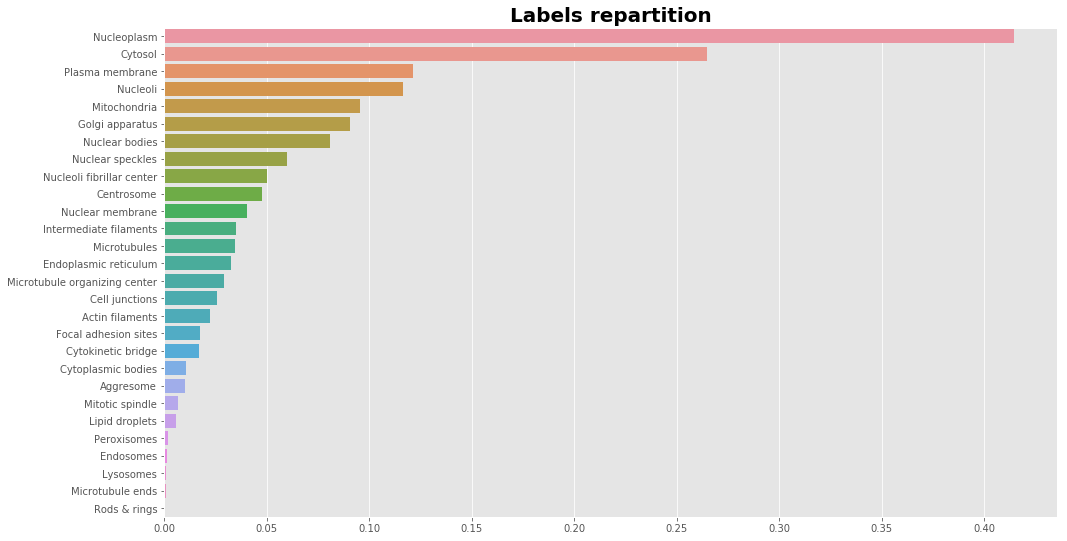

In [8]:
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

# Create columns for each label in DF_TRAIN_LAB
for v in label_names.values():
    DF_TRAIN_LAB[v] = 0 

DF_TRAIN_LAB = DF_TRAIN_LAB.apply(fill_targets, axis=1)
df_train_lab = DF_TRAIN_LAB.iloc[:, 2:]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
counts_labels = df_train_lab.sum(axis=0).sort_values(ascending=False)/n_train
sns.barplot(y=counts_labels.index, x=counts_labels.values, ax=ax)
ax.set_title("Labels repartition", fontsize=20, fontweight="bold")
plt.show(fig)

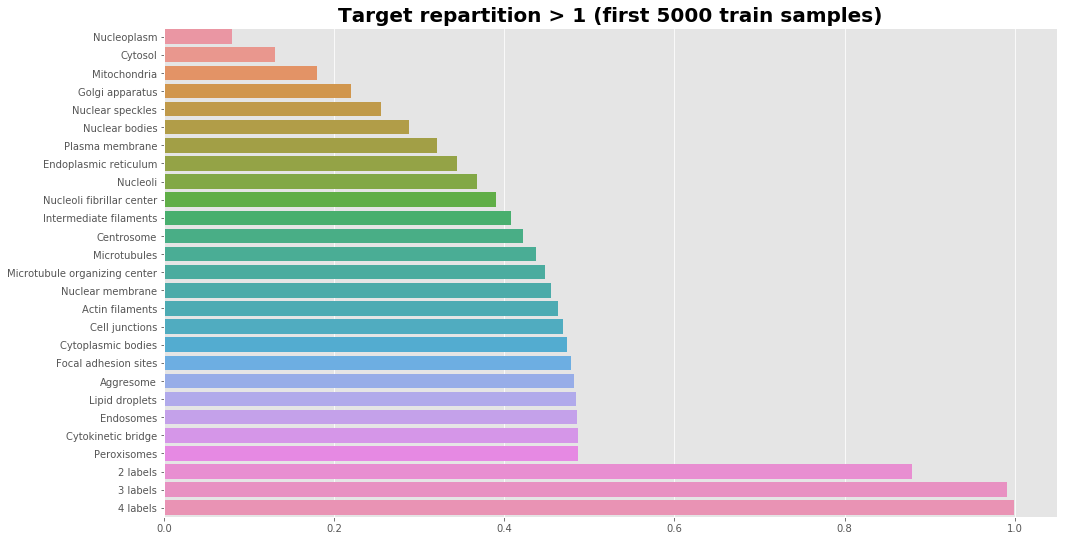

CPU times: user 17.1 s, sys: 192 ms, total: 17.3 s
Wall time: 17.1 s


In [9]:
%%time
n_plot = 5000 # Use first 5000 training samples to compute target repartition
counts_target = DF_TRAIN_LAB.iloc[:n_plot].Target.value_counts()
counts_target = counts_target.loc[counts_target > 1]

new_index = []
for i, idx in enumerate(counts_target.index):
    tmp = list(np.vectorize(label_names.get)(idx))
    tmp = "-".join(tmp)
    new_index.append(tmp)
    
df_counts_target = counts_target.to_frame("count")
df_counts_target["tmp"] = new_index
df_counts_target = df_counts_target.set_index("tmp", drop=True)

# Add 2 labels, 3 labels and 4 labels targets
df_multi_labels = pd.DataFrame(columns=["count"])
for i in [2,3,4]:
    df_multi_labels.loc["%d labels" % i] = [(df_train_lab.iloc[:n_plot].sum(axis=1)==i).sum()]

df_counts_target = df_counts_target.append(df_multi_labels)
counts_target = df_counts_target.iloc[:,0] 

# Let's plot cumulative frequency
counts_target = counts_target.cumsum()/n_plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
sns.barplot(y=counts_target.index, x=counts_target.values, ax=ax)
ax.set_title("Target repartition > 1 (first %d train samples)" % n_plot, fontsize=20, fontweight="bold")
plt.show(fig)

In [10]:
def plot_corr_matrix(df, ax, clustering=False):
    corr = df.corr()    
    if clustering:
        d = sch.distance.pdist(corr)
        L = sch.linkage(d, method='complete')
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
        df_reindex = df.reindex_axis(columns, axis=1)
        corr = df_reindex.corr()

    # Generate mask for upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

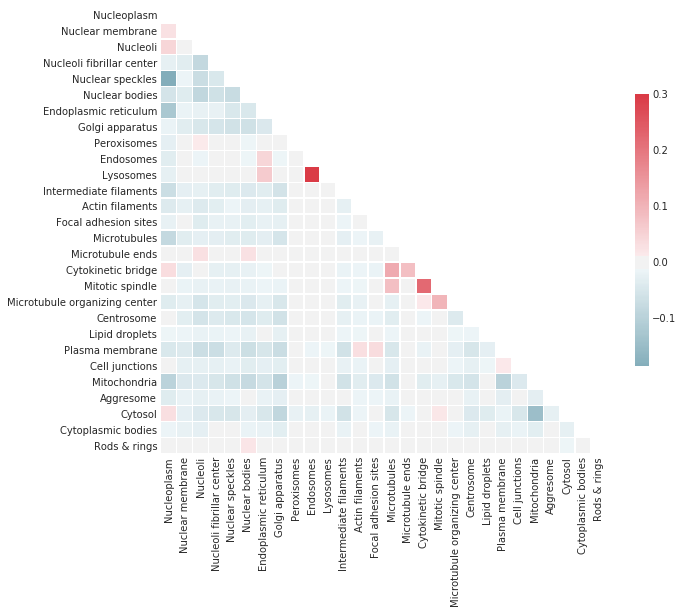

In [11]:
plt.style.use(style='seaborn-white')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_corr_matrix(df_train_lab, ax=ax)
plt.show(fig)
plt.style.use('ggplot')

### 1.2 Repartition of number of labels

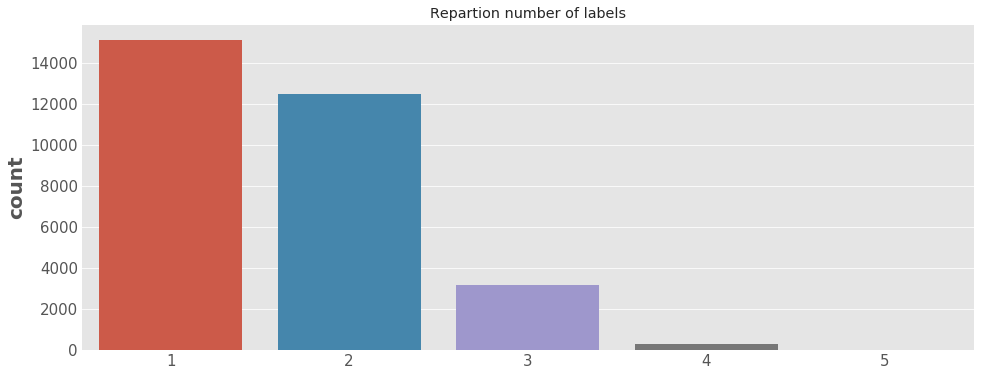

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
counts_labels = df_train_lab.sum(axis=1).sort_values(ascending=False)
sns.countplot(counts_labels, ax=ax)
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
ax.set_ylabel('count', fontsize=20, fontweight='bold')
ax.set_title("Repartion number of labels")
plt.show(fig)

# 2. Exploration of images

In [13]:
%%time
train_path = "../input/human-protein-atlas-image-classification/train/"
test_path = "../input/human-protein-atlas-image-classification/test/"
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size
print("Total size of train folder %.3f GB" % (get_size(start_path=train_path)/2**30))
print("Total size of test folder %.3f GB" % (get_size(start_path=test_path)/2**30))

Total size of train folder 0.000 GB
Total size of test folder 0.000 GB
CPU times: user 494 µs, sys: 383 µs, total: 877 µs
Wall time: 537 µs


As you can see below, each samples consists of 4 images for 4 different colors: red, blue, yellow and green.

In [14]:
files = os.listdir(train_path)
for n in range(10):
    print(files[n])

FileNotFoundError: [Errno 2] No such file or directory: '../input/human-protein-atlas-image-classification/train/'

Use an iterator to load the images and define functions to plot each channel.

In [ ]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    for ax in subax:
        ax.axis('off')
        ax.grid(False)
    return subax

def make_title(file_id):
    file_targets = DF_TRAIN_LAB.loc[DF_TRAIN_LAB.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [ ]:
class TargetGroupIterator:
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_label_names[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        DF_TRAIN_LAB["check_col"] = DF_TRAIN_LAB.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = DF_TRAIN_LAB[DF_TRAIN_LAB.check_col==1].Id.values
        DF_TRAIN_LAB.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(targets).issubset(set(self.target_list)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images         

## Lysosomes - Endosomes

In [ ]:
batch_size = 3
imageloader = TargetGroupIterator(target_names=["Lysosomes", "Endosomes"], batch_size=batch_size, basepath=train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

file_ids, images = next(iterator)
fig, ax = plt.subplots(len(file_ids),4,figsize=(16,4*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

## Nuclear membrane

In [ ]:
batch_size = 3
imageloader = TargetGroupIterator(target_names=["Nuclear membrane"], batch_size=batch_size, basepath=train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

file_ids, images = next(iterator)
fig, ax = plt.subplots(len(file_ids),4,figsize=(16,4*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

## Rods & rings

In [ ]:
batch_size = 3
imageloader = TargetGroupIterator(target_names=["Rods & rings"], batch_size=batch_size, basepath=train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

file_ids, images = next(iterator)
fig, ax = plt.subplots(len(file_ids),4,figsize=(16,4*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

# 2. Toy models

In [15]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import PIL.Image as Image
os.system("! pip install cnn_finetune")
from cnn_finetune import make_model
import xgboost as xgb

import gc
gc.enable()

ModuleNotFoundError: No module named 'xgboost'

Create functions to train the model using mini-batches. The idea is to minimize a given loss on the outputs of the models by backpropagation the error using stochastic gradient descent.  An epoch is a complete pass on the chosen training set. We can choose to pass several times in a different order on a dataset to further improve the performance of the model.

In [ ]:
# once the images are loaded, we pre-process them before being passed into the network
# and normalize them to mean = 0 and standard-deviation = 1
# mean and std vectors are standard for pretrained models

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#########################################################
# Train and validation functions for CNN trained with SGD
#########################################################

def train(epoch, model, train_loader, n_fit, batch_size, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy = 100. * correct / list(target.size())[0]
        accuracy = accuracy.data.numpy()
        f1_multiclass = f1_score(y_true = target.cpu().data.numpy(), y_pred=pred.cpu().data.numpy(), average="macro")
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f} Accuracy {:.4f} F1-Macro multiclass {:.4f}'.format(
                epoch, batch_idx * len(data), n_fit,
                100. * batch_idx / np.int(n_fit / batch_size), loss.data.item(), accuracy, f1_multiclass))
    return model

def validation(model, val_loader, n_val):
    model.eval()
    validation_loss = 0
    correct = 0
    
    batches_pred = []
    batches_target = []
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
        validation_loss += criterion(output, target).data.item()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        batches_pred.append(pred.cpu().data.numpy())
        batches_target.append(target.cpu().data.numpy())
        
    pred = np.concatenate(batches_pred, axis=0)
    target = np.concatenate(batches_target, axis=0)
    f1_multiclass = f1_score(y_true=target, y_pred=pred, average="macro")
    validation_loss /= n_val
    accuracy = 100. * correct / n_val
    accuracy = accuracy.data.numpy()
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) F1-Macro multiclass {:.4f}\n'.format(
        validation_loss, correct, n_val, accuracy, f1_multiclass))
    return accuracy

def default_loader(path):
    red    = Image.open(path + '_red.png')
    green  = Image.open(path + '_green.png')
    blue   = Image.open(path + '_blue.png')
    return Image.merge("RGB",(red,green,blue))

def make_predictions(model, test_path, outfile, DF_TEST_LAB, class_to_label):
    output_file = open(outfile, "w")
    output_file.write("Id,Predicted\n")
    print("Making predictions on the test set...")
    for Id in tqdm(DF_TEST_LAB.Id):
        data = data_transforms(default_loader(os.path.join(test_path, Id)))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()

        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        pred = class_to_label[np.int(pred.data.cpu().numpy())] # Map to original label class
        output_file.write("%s,%d\n" % (Id, pred))
    
    output_file.close()
    print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website\n')

In [ ]:
class ImageFileList(torch.utils.data.Dataset):
    def __init__(self, root, list_imnames, list_targets, transform=None, loader=default_loader):
        self.root = root
        self.list_imnames = list_imnames
        self.list_targets = list_targets
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        imname, target = self.list_imnames[index], self.list_targets[index]
        img = self.loader(os.path.join(self.root,imname))
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.list_imnames)

## 2.1 Gross multiclass classification

In a first approximation, we are going to create single-label classes so that the problem is **reduced to a multiclass classification**. There will be a class for each of the 24 unique labels that appear at least twice in the first 5000 samples of the train set (see graphs part 1.).

In [ ]:
n_plot = 5000 # Use first 5000 training samples to compute target repartition
counts_target = DF_TRAIN_LAB.iloc[:n_plot].Target.value_counts()
counts_target = counts_target.loc[counts_target > 1]

new_index = []
for i, idx in enumerate(counts_target.index):
    tmp = list(np.vectorize(label_names.get)(idx))
    tmp = "-".join(tmp)
    new_index.append(tmp)
    
df_counts_target = counts_target.to_frame("count")
df_counts_target["tmp"] = new_index
df_counts_target = df_counts_target.set_index("tmp", drop=True)

# dictionary of class labels
class_names = {i:x for i,x in enumerate(df_counts_target.index)}
class_names[len(class_names)] = "2 labels"
class_names[len(class_names)] = "3 labels"
class_names[len(class_names)] = "4 labels"
class_names[len(class_names)] = "other"
class_names_reversed = {v:k for k,v in class_names.items()}

# Dict to map back to the original labels when making predictions
class_to_label = {k1:k2 for k1, v1 in class_names.items() for k2,v2 in label_names.items() if v1==v2}
for k in class_names.keys():
    if k not in class_to_label.keys():
        class_to_label[k] = 0

In [ ]:
DF_TRAIN_LAB["n_labels"] = DF_TRAIN_LAB.iloc[:, 2:].sum(axis=1)
DF_TRAIN_LAB["Class"] = class_names_reversed["other"]

# Associates training samples to their class
def convert_to_label(x):
    if x[0] in class_names.keys():
        return x[0]
    else:
        return class_names_reversed["other"]
    
DF_TRAIN_LAB.loc[DF_TRAIN_LAB.n_labels==1, "Class"] = DF_TRAIN_LAB.loc[DF_TRAIN_LAB.n_labels==1].Target.apply(convert_to_label)
DF_TRAIN_LAB.loc[DF_TRAIN_LAB.n_labels==2, "Class"] = class_names_reversed["2 labels"]
DF_TRAIN_LAB.loc[DF_TRAIN_LAB.n_labels==3, "Class"] = class_names_reversed["3 labels"]
DF_TRAIN_LAB.loc[DF_TRAIN_LAB.n_labels==4, "Class"] = class_names_reversed["4 labels"]

In [ ]:
# Training settings
train_path = "../input/human-protein-atlas-image-classification/train"
seed = 1
batch_size = 64
log_interval = 10
experiment = "../working/experiment/"
test_path = "../input/human-protein-atlas-image-classification/test"
momentum = 0.9
nepoch = 5
nclasses = len(class_names)
lr = 0.01

use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)

# Create experiment folder
if not os.path.isdir(experiment):
    os.makedirs(experiment)
    
# Settings for data loading
np.random.seed(seed)

n_fit_limit = np.int(n_train*2/3)
n_fit = 1500
n_val = 500

## Pretrained models + default multiclass classifier

In [ ]:
# First train complete CNN with pretrained models
# Parameters of last layers of pretrained models are retrained

classifier_label = "default"
pretrained_models = ["se_resnet50", "inceptionresnetv2", "inception_v3", "densenet121"]
validation_results = pd.DataFrame(columns=["pretrained", "classifier", "lr", "epoch", "accuracy"])

for pretrained in pretrained_models:
    if not os.path.isdir("experiment/%s" % pretrained):
        os.mkdir("experiment/%s" % pretrained)
        
    for classifier_label in ["default"]:
        if classifier_label == "default":
            model = make_model(pretrained, num_classes=nclasses, pretrained=True, input_size=(224, 224))
        else:
            model = make_model(pretrained, num_classes=nclasses, pretrained=True, input_size=(224, 224), classifier_factory=eval(classifier_label))
            
        # Because CUDA memory is limited, we can't update all parameters of pretrained models
        if pretrained == "densenet121":
            # Let weights of first 2 layers unchanged
            for param in list(model.children())[0][0].parameters():
                param.requires_grad = False
            for param in list(model.children())[0][1].parameters():
                param.requires_grad = False

            # _Dense Block is composed of 6 dense layers
            # Let weights of first 3 layers unchanged
            for i in range(3):
                for param in list(model.children())[0][4][i].parameters():
                    param.requires_grad = False

        elif pretrained == "inception_v3":
            # First 7 layers of inception_v3 are BasicConv2d and MaxPool2D
            # Next 4 are InceptionA layers
            for i in range(11):
                for param in list(model.children())[0][i].parameters():
                    param.requires_grad = False

        elif pretrained == "se_resnet50":
            # CUDA memory is enough to update all parameters
            pass
        
        elif pretrained == "inceptionresnetv2":
            # First 15 layers, only update params of last one
            for i in range(14):
                for param in list(model.children())[0][i].parameters():
                    param.requires_grad = False

        print("#"*40)
        print("Model specifications")
        print("Pretrained: %s" % pretrained)
        print("Classifier: %s" % classifier_label)
        print("SGD learning rate: %s" % lr)
        if use_cuda:
            print('Using GPU')
            model.cuda()
        else:
            print('Using CPU')
        print("#"*40)
        print("\n")

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        # Train the model on the selected epoch on the train dataset and then compute validation accuracy on val dataset
        for epoch in range(1, nepoch + 1):
            rand_rows_fit = np.random.permutation(n_fit_limit)
            rand_rows_val = np.random.permutation(range(n_fit_limit, n_train))
            
            fit_data = ImageFileList(root=train_path, list_imnames=DF_TRAIN_LAB.Id[rand_rows_fit[:n_fit]].values, 
                                     list_targets=DF_TRAIN_LAB.Class[rand_rows_fit[:n_fit]].values, transform=data_transforms)
            val_data = ImageFileList(root=train_path, list_imnames=DF_TRAIN_LAB.Id[rand_rows_val[:n_val]].values, 
                                     list_targets=DF_TRAIN_LAB.Class[rand_rows_val[:n_val]].values, transform=data_transforms)

            train_loader = torch.utils.data.DataLoader(fit_data, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = torch.utils.data.DataLoader(val_data, batch_size=6, shuffle=False, num_workers=0)
            
            train(epoch, model, train_loader, n_fit, batch_size, optimizer) # Use mini-batches of size batch_size
            accuracy = validation(model, val_loader, n_val)

            row = {"pretrained": pretrained, "classifier": classifier_label, "lr": lr, "epoch": epoch, "accuracy": accuracy}
            validation_results = validation_results.append(row, ignore_index=True)
            validation_results.to_csv("../working/experiment/validation_results.csv")

            # Make predictions on test images
            model.eval()
            if use_cuda:
                model.cuda()

            outfile = "../working/experiment/%s/kaggle_%s_%s_epoch%d.csv" % (pretrained, pretrained, classifier_label, epoch)
            make_predictions(model, test_path, outfile, DF_TEST_LAB, class_to_label)
            
        print("*"*40)
        print("Memory usage before freeing memory")
        !nvidia-smi
        print("*"*40)
            
        # Free cuda memory
        del model ; gc.collect()
        torch.cuda.empty_cache()

In [ ]:
list(target.size())[0]

In [ ]:
model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data)
    criterion = torch.nn.CrossEntropyLoss(reduction='elementwise_mean')
    loss = criterion(output, target)
    f1 = f1_score(y_true = target.cpu().data.numpy(), y_pred=output.cpu().data.numpy(), average="macro")
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} F1-Macro {:.4f}'.format(
            epoch, batch_idx * len(data), n_fit,
            100. * batch_idx / np.int(n_fit / batch_size), loss.data.item(), f1))

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(df)

# ↓ ↓ ↓  Yay, download link! ↓ ↓ ↓ 

In [ ]:
DF_TEST_LAB.head()

In [ ]:
df = pd.read_csv("../working/experiment/se_resnet50/kaggle_se_resnet50_default_epoch1.csv")

In [ ]:
df.Predicted.value_counts()

 ## MajorityVote classifier

In [ ]:
from scipy.stats import mode

######################################################
# Code that mixes predictions of the differents models
# One technique is used majority vote to classify
######################################################

path = "../working/experiment/"
threshold = 5

# Read output files
vals = validation_results
output = pd.read_csv(path + "densenet121/kaggle_densenet121_default_epoch1.csv", usecols=["Id"])
        
# Select predictions of models having validation performance above threshold
outputs_model = pd.DataFrame.copy(output)
del outputs_model["Id"]
for pretrained in vals.pretrained.unique():
    for classifier in vals.classifier.unique():
        for epoch in vals.epoch.unique():
            mask = (vals.pretrained == pretrained) & (vals.classifier == classifier) & (vals.epoch == epoch)
            if mask.sum() > 0:
                accuracy = vals[mask]["accuracy"].values[0]
                name = "Category_%s_%s_%s" % (pretrained, classifier, epoch)

                outfile = "%s/kaggle_%s_%s_epoch%d.csv" % (pretrained, pretrained, classifier, epoch)
                out = pd.read_csv(path  + outfile)

                if accuracy >= threshold:
                    outputs_model.loc[:, name] = out["Category"]
                
output.loc[:, "Predicted"] = outputs_model.apply(lambda x: mode(x)[0][0], axis=1)
output.to_csv("output.csv", index=False)